This notebook extends Kate's work on generating forcing files for the tides at Johnstone Strait. Kate's notebook is based on observations from Thomson and Huggett (1980). Unfortunately, their observations are not long enough to retrieve the smaller tidal constuents: O1, S2, N2, P1, Q1, K2.

To determine these constituents, we will calculate the amplitude and phase change of the M2/K1 harmonics between the Webtide point closest to our boundary and the Johnstone Strait harmonics that Kate has determined. We will apply the same change to the remaining constituents. 

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np
from math import cos, sin, tan, radians
import math
import webtide_tools

In [2]:
TSin =  {'West': {'K1': {'Amp': 1.0271144154661969, 'Pha': -5.0631505995348336}, 'S2': {'Amp': 1.0179855513962961, 'Pha': 0.51874089168708881}, 'Q1': {'Amp': 0.95456532912462688, 'Pha': 1.3607910947190214}, 'M2': {'Amp': 0.88588845055894749, 'Pha': -7.6837102730006226}, 'O1': {'Amp': 1.0517458539629139, 'Pha': 0.71408256198132802}, 'N2': {'Amp': 0.99918535328746982, 'Pha': 2.4061643764855036}}, 'North': {'K1': {'Amp': 0.79871902632681224, 'Pha': 0.0}, 'S2': {'Amp': 0.96011938251026929, 'Pha': -9.0550538391048025}, 'Q1': {'Amp': 1.0276402992531077, 'Pha': 9.7195174921122032}, 'M2': {'Amp': 1.3628664777853992, 'Pha': 12.157878255008042}, 'O1': {'Amp': 0.8746088145989217, 'Pha': 4.6022946544676699}, 'N2': {'Amp': 0.95621083871729562, 'Pha': -6.3740881178157833}}}

In [3]:
# These are the corrections to be used.
code = 'N36_V'
# Fine tuning corrections, note that these are relative to M2/K1  P1 and K2 calculated as fixed ratios (see below)
amp_corr = {
    'O1': TSin['North']['O1']['Amp'], 
    'S2': TSin['North']['S2']['Amp'], 
    'P1': 0., 
    'N2': TSin['North']['N2']['Amp'], 
    'Q1': TSin['North']['Q1']['Amp'], 
    'K2': 0.}
pha_corr = {
    'O1': np.radians(TSin['North']['O1']['Pha']),
    'S2': np.radians(TSin['North']['S2']['Pha']), 
    'P1': 0.*np.pi/180., 
    'N2': np.radians(TSin['North']['N2']['Pha']), 
    'Q1': np.radians(TSin['North']['Q1']['Pha']), 
    'K2': 0.*np.pi/180.0}


Load the NETCDF tidal data from the north.

In [4]:
def get_files(constituent,code):
    #returns the U, V, T netcdf handles for the tidal constiruents that Kate created for the northern boundary
    #constituent = 'O1', 'M2', etc
    filename = 'SalishSea_'+code+'_North_tide_' + constituent
        
    fU=NC.Dataset(filename + '_grid_U.nc', 'r')
    fV=NC.Dataset(filename + '_grid_V.nc', 'r')
    fT=NC.Dataset(filename + '_grid_T.nc', 'r')
    
    return fU, fV, fT


In [5]:
consts_full= {'M2': [], 'K1': [], 'O1': [], 'S2': [], 'N2': [], 'P1': [], 'Q1': [], 'K2': []}
consts_North= {'M2': [], 'K1': []}

fUs_North={}
fVs_North={}
fTs_North={}

for key in consts_North:
    [fUs_North[key], fVs_North[key],fTs_North[key]]= get_files(key,code)
      

NEMO takes the harmonics as :

$Z_1 = A \cos(\phi)$

$Z_2 = A \sin(\phi)$

Where $A$ and $\phi$ are the amplitude and phase. 

So: $A = \sqrt(Z_1^2+Z_2^2)$ and $ \phi = \arctan(Z_2/Z_1)$ 

In [6]:
def get_harmomincs(f, comp):
    #returns the harmonics as vecotors
    #f is the nertcdf handle
    #comp is the component ('U','V','T')
    import numpy as np
    import math
    
    if comp=='U':
        x1='u1'; x2='u2';
        
    elif comp == 'V':
        x1='v1'; x2='v2';
        
    elif comp == 'T':
        x1='z1'; x2='z2';
        
    X1=f.variables[x1]; X1=np.array(X1); X1=X1.flatten();
    X2=f.variables[x2]; X2=np.array(X2); X2=X2.flatten();
    amp = np.sqrt(X1[:]**2 + X2[:]**2);
    pha=[]
    for i in range(0,len(amp)):
        pha.append(math.atan2(X2[i],X1[i]))
    
    pha = np.array(pha)
    pha = pha + (pha<0)*2*np.pi
            
    
    return amp, pha

Open the NETCDF files and retrieve the constituents at the North. These are the ones that Kate calculated from Thomson and Huggett (1980). This data is relative to the NEMO grid rotation. 

In [7]:
Us_North_amp = {}; Us_North_pha = {}
Vs_North_amp = {}; Vs_North_pha = {}
Ts_North_amp = {}; Ts_North_pha = {}

for key in consts_North:
    [Us_North_amp[key], Us_North_pha[key]]= get_harmomincs(fUs_North[key],'U')
    [Vs_North_amp[key], Vs_North_pha[key]]= get_harmomincs(fVs_North[key],'V')
    [Ts_North_amp[key], Ts_North_pha[key]]= get_harmomincs(fTs_North[key],'T')




Get the tidal elevation constituents from the nearby Webtide point.

Note: Kate has the tidal elevation constituents from webtide saved in webtide_point_johnstone_strait.csv. I had to retrieve the current constituents.

To do this, I launched Webtide, created a tidal marker at the Lat/Lon from Kate's webtide point. Then I pressed "Get Harmonics" with currents selected. Webtide outputs an html file which I saved and then copied to a csv file. 

The data is in:
Currents: /data/nsoontie/MEOPAR/tools/I_ForcingFiles/Tides/Webtide_Current_Constituents_North.csv

Elevation: /data/nsoontie/MEOPAR/tools/I_ForcingFiles/Tides/webtide_point_johnstone_strait.csv


In [8]:
def get_webtide_data(constituent):
    # returns the phase and amplitude of a constituent from webtide. Takes into account the rotation of the grid.
    # constituent is eg 'M2', 'K1', etc...
    # this is based on Kate's function get_data_from_csv() in webtide_tools 
    # returns the T,U,V phase (radians) and amplitude for the NEMO grid (ie rotated)
    # uses Kate's method of rotating the currents from webtide. See Data acquisition in docs

    import pandas as pd
    import math
    import numpy as np
    
    theta = math.radians(29);
    webtide_curr = pd.read_csv('Webtide_Current_Constituents_North.csv',\
                                 skiprows = 2)
    webtide_curr = webtide_curr.rename(columns={'Constituent': 'const', 'Longitude': 'lon', 'Latitude': 'lat', \
                                          'U Amplitude (m)': 'ewamp', 'U Phase (deg GMT)': 'ewpha',\
                                          'V Amplitude (m)': 'nsamp', 'V Phase (deg GMT)': 'nspha'})

    #Convert phase from north/south into grid co-ordinates (see docs/tides/tides_data_acquisition for details)
    ua = webtide_curr[webtide_curr.const==(constituent)].ewamp
    va = webtide_curr[webtide_curr.const==(constituent)].nsamp
    uphi = math.radians(webtide_curr[webtide_curr.const==(constituent)].ewpha)
    vphi = math.radians(webtide_curr[webtide_curr.const==(constituent)].nspha)
        
    uZ1 = ua*math.cos(theta)*math.cos(uphi) - va*math.sin(theta)*math.sin(vphi)
    uZ2 = ua*math.cos(theta)*math.sin(uphi) + va*math.sin(theta)*math.cos(vphi)
    
    vZ1 = -ua*math.sin(theta)*math.cos(uphi) - va*math.cos(theta)*math.sin(vphi)
    vZ2 = -ua*math.sin(theta)*math.sin(uphi) + va*math.cos(theta)*math.cos(vphi)
    
    #Now get the phase and amplitude for U on NEMO grid
    U_amp = math.sqrt(uZ1**2 +uZ2**2);
    U_pha=math.atan2(uZ2,uZ1)
    U_pha = U_pha + (U_pha<0)*2*np.pi;
        
    #Now get the phase and amplitude for V on NEMO grid
    V_amp = math.sqrt(vZ1**2 +vZ2**2);
    V_pha=math.atan2(vZ2,vZ1)
    V_pha = V_pha + (V_pha<0)*2*np.pi;
        
    #Now get the webtide data for elevation. This is much easier since we don't have to worry about rotation.
    webtide_elev = pd.read_csv('webtide_point_johnstone_strait.csv',\
                              skiprows = 2)
    webtide_elev = webtide_elev.rename(columns={'Constituent': 'const', 'Longitude': 'lon', 'Latitude': 'lat', \
                                          'Amplitude (m)': 'amp', 'Phase (deg GMT)': 'pha'})
        
    T_amp = np.array(webtide_elev[webtide_elev.const==(constituent)].amp)[0]
    T_pha = np.radians(np.array(webtide_elev[webtide_elev.const==(constituent)].pha)[0])
    T_pha = T_pha + (T_pha<0)*2*np.pi;
    
    return U_amp, U_pha, V_amp, V_pha, T_amp, T_pha

In [9]:
#Get all the webtide data
Us_web_amp={}
Us_web_pha={}
Vs_web_amp={}
Vs_web_pha={}
Ts_web_amp={}
Ts_web_pha={}

for key in consts_full:
    [Us_web_amp[key], Us_web_pha[key], Vs_web_amp[key],
     Vs_web_pha[key], Ts_web_amp[key], Ts_web_pha[key]] = get_webtide_data(key)


Check on the calculations from webtide and Northern tides by plotting.

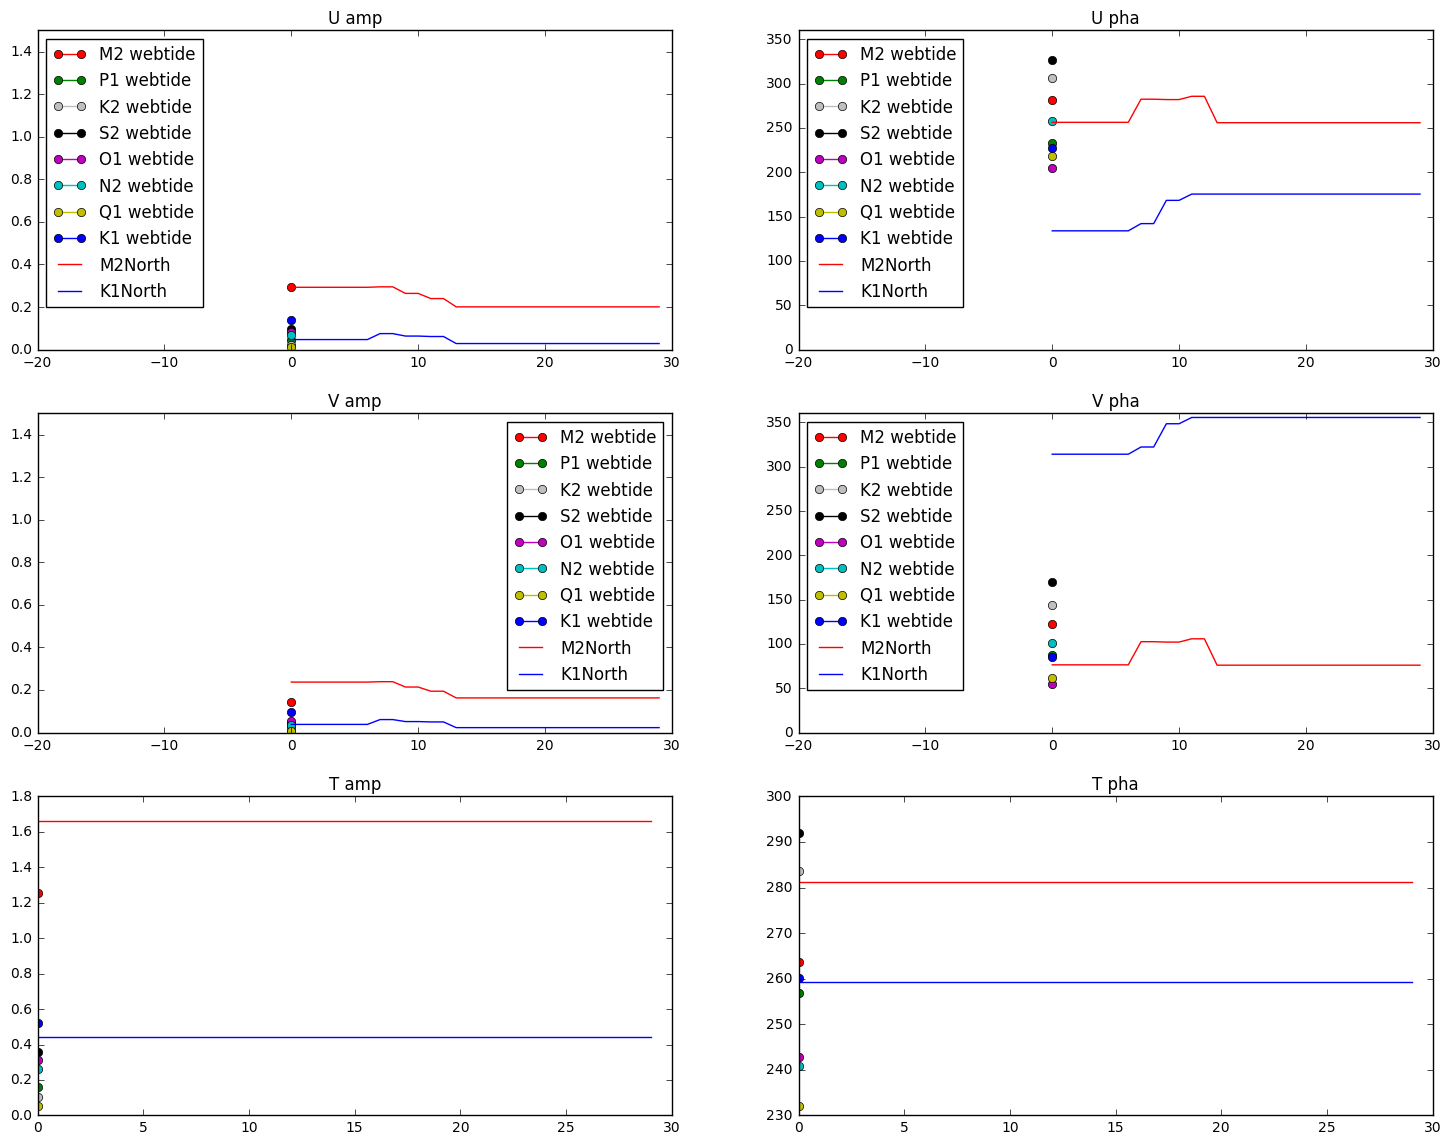

In [10]:
#West
amp = [-20, 30, 0, 1.5]
pha = [-20, 30, 0, 360]
cols = {'M2':'r', 'K1': 'b','O1': 'm', 'S2': 'k','P1': 'g', 'N2': 'c', 'Q1': 'y', 'K2': '0.75'}
plt.figure(figsize=(18,14))

for key in consts_full:
    pylab.subplot(3,2,1)
    pylab.plot(Us_web_amp[key],cols[key],marker ='o',label=key + ' webtide')
    pylab.title('U amp')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,2)
    pylab.plot(np.degrees(Us_web_pha[key]),cols[key],marker ='o',label=key + ' webtide')
    pylab.title('U pha')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,3)
    pylab.plot(Vs_web_amp[key],cols[key], marker ='o',label=key + ' webtide')
    pylab.title('V amp')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,4)
    pylab.plot(np.degrees(Vs_web_pha[key]),cols[key], marker ='o',label=key + ' webtide')
    pylab.title('V pha')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,5)
    pylab.plot(Ts_web_amp[key],cols[key],marker ='o',label=key+ ' webtide')
    pylab.title('T amp')
    
    pylab.subplot(3,2,6)
    pylab.plot(np.degrees(Ts_web_pha[key]),cols[key], marker ='o',label=key+ 'webtide')
    pylab.title('T pha')    

    
for key in consts_North:
    pylab.subplot(3,2,1)
    pylab.plot(Us_North_amp[key],cols[key],label=key + 'North')
    pylab.title('U amp')
    pylab.legend(loc=0)
    pylab.axis(amp)
    
    pylab.subplot(3,2,2)
    pylab.plot(np.degrees(Us_North_pha[key]),cols[key],label=key + 'North')
    pylab.title('U pha')
    pylab.legend(loc=0)
    pylab.axis(pha)
    
    pylab.subplot(3,2,3)
    pylab.plot(Vs_North_amp[key],cols[key], label=key + 'North')
    pylab.title('V amp')
    pylab.legend(loc=0)
    pylab.axis(amp)
    
    pylab.subplot(3,2,4)
    pylab.plot(np.degrees(Vs_North_pha[key]),cols[key], label=key + 'North')
    pylab.title('V pha')
    pylab.legend(loc=0)
    pylab.axis(pha)
    
    pylab.subplot(3,2,5)
    pylab.plot(Ts_North_amp[key],cols[key],label=key+ 'North')
    pylab.title('T amp')
    
    pylab.subplot(3,2,6)
    pylab.plot(np.degrees(Ts_North_pha[key]),cols[key], label=key+ 'North')
    pylab.title('T pha')
    

          

Now, we will see how much the amplitudes and phases have changed between webtide and our tuned values.

If the M2 tide amplitude has changed by a factor $R$, then we will assume the S2 tide ampltiude has changed by a factor $R$. So,

$\frac{M_{2 North}}{ M_{2 Webtide}} = \frac{S_{2 North}}{ S_{2 Webtide}}$.

This means
$S_{2 North} = S_{2 Webtide}\frac{M_{2 North}}{ M_{2 Webtide}}$


If the M2 tide phase has changed by $\Delta$ then we will assume that the S2 tide phase has also changed by $\Delta$. Or,

$M_{2 North} - M_{2 Webtide} = S_{2 North} - S_{2 Webtide}$.

This means
$S_{2 North} = S_{2 Webtide} + \Delta$,

where $\Delta =M_{2 North} - M_{2 Webtide}$.


In [11]:
Us_ratio_amp = {}
Vs_ratio_amp = {}
Ts_ratio_amp = {}

Us_diff_pha= {}
Vs_diff_pha = {}
Ts_diff_pha = {}



for key in consts_North:   # M2 and K1
    Us_ratio_amp[key] = Us_North_amp[key]/Us_web_amp[key];
    Vs_ratio_amp[key] = Vs_North_amp[key]/Vs_web_amp[key];
    Ts_ratio_amp[key] = Ts_North_amp[key]/Ts_web_amp[key];

    Us_diff_pha[key] = Us_North_pha[key]- Us_web_pha[key];
    Vs_diff_pha[key] = Vs_North_pha[key]- Vs_web_pha[key];
    Ts_diff_pha[key] = Ts_North_pha[key]- Ts_web_pha[key];


In [12]:
print (Us_ratio_amp)
print (Us_diff_pha)

{'M2': array([ 0.99436915,  0.99436915,  0.99436915,  0.99436915,  0.99436915,
        0.99436915,  0.99436915,  1.0018748 ,  1.0018748 ,  0.89681756,
        0.89681756,  0.8144899 ,  0.8144899 ,  0.68212759,  0.68212759,
        0.68212759,  0.68212759,  0.68212759,  0.68212759,  0.68212759,
        0.68212759,  0.68212759,  0.68212759,  0.68212759,  0.68212759,
        0.68212759,  0.68212759,  0.68212759,  0.68212759,  0.68212759], dtype=float32), 'K1': array([ 0.33954549,  0.33954549,  0.33954549,  0.33954549,  0.33954549,
        0.33954549,  0.33954549,  0.54227602,  0.54227602,  0.45839283,
        0.45839283,  0.44325799,  0.44325799,  0.20449899,  0.20449899,
        0.20449899,  0.20449899,  0.20449899,  0.20449899,  0.20449899,
        0.20449899,  0.20449899,  0.20449899,  0.20449899,  0.20449899,
        0.20449899,  0.20449899,  0.20449899,  0.20449899,  0.20449899], dtype=float32)}
{'M2': array([-0.43188896, -0.43188896, -0.43188896, -0.43188896, -0.43188896,
       -0.

Compute the new Northern amplitudes and phases based on the ratios and make any fine-tuning changes here too.

In [13]:
consts_2 = {'S2': [], 'N2': []}
consts_1 = {'O1': [], 'Q1': []}
# Fine tuning corrections moved to top of notebook
 
# 2 tides
for key in consts_2:
    Us_North_amp[key] = Us_web_amp[key]*Us_ratio_amp['M2']*amp_corr[key]
    Vs_North_amp[key] = Vs_web_amp[key]*Vs_ratio_amp['M2']*amp_corr[key]
    Ts_North_amp[key] = Ts_web_amp[key]*Ts_ratio_amp['M2']*amp_corr[key]
    
    Us_North_pha[key] = Us_web_pha[key] + Us_diff_pha['M2'] + pha_corr[key]
    Vs_North_pha[key] = Vs_web_pha[key] + Vs_diff_pha['M2'] + pha_corr[key]
    Ts_North_pha[key] = Ts_web_pha[key] + Ts_diff_pha['M2'] + pha_corr[key]
    
# 1 tides
for key in consts_1:
    Us_North_amp[key] = Us_web_amp[key]*Us_ratio_amp['K1']*amp_corr[key]
    Vs_North_amp[key] = Vs_web_amp[key]*Vs_ratio_amp['K1']*amp_corr[key]
    Ts_North_amp[key] = Ts_web_amp[key]*Ts_ratio_amp['K1']*amp_corr[key]
    
    Us_North_pha[key] = Us_web_pha[key] + Us_diff_pha['K1'] + pha_corr[key]
    Vs_North_pha[key] = Vs_web_pha[key] + Vs_diff_pha['K1'] + pha_corr[key]
    Ts_North_pha[key] = Ts_web_pha[key] + Ts_diff_pha['K1'] + pha_corr[key]

# can't resolve K2, fix these
Us_North_amp['K2'] = Us_North_amp['S2'] * 0.28; Vs_North_amp['K2'] = Vs_North_amp['S2'] * 0.28
Ts_North_amp['K2'] = Ts_North_amp['S2'] * 0.28
Us_North_pha['K2'] = Us_North_pha['S2']-7*np.pi/180.; Vs_North_pha['K2'] = Vs_North_pha['S2']-7*np.pi/180.;
Ts_North_pha['K2'] = Ts_North_pha['S2']-7*np.pi/180.
# can't resolve P1, fix these
Us_North_amp['P1'] = Us_North_amp['K1'] * 0.306; Vs_North_amp['P1'] = Vs_North_amp['K1'] * 0.306
Ts_North_amp['P1'] = Ts_North_amp['K1'] * 0.306
Us_North_pha['P1'] = Us_North_pha['K1']-3*np.pi/180.; Vs_North_pha['P1'] = Vs_North_pha['K1']-3*np.pi/180.;
Ts_North_pha['P1'] = Ts_North_pha['K1']-3*np.pi/180.

Plot the results to check. 

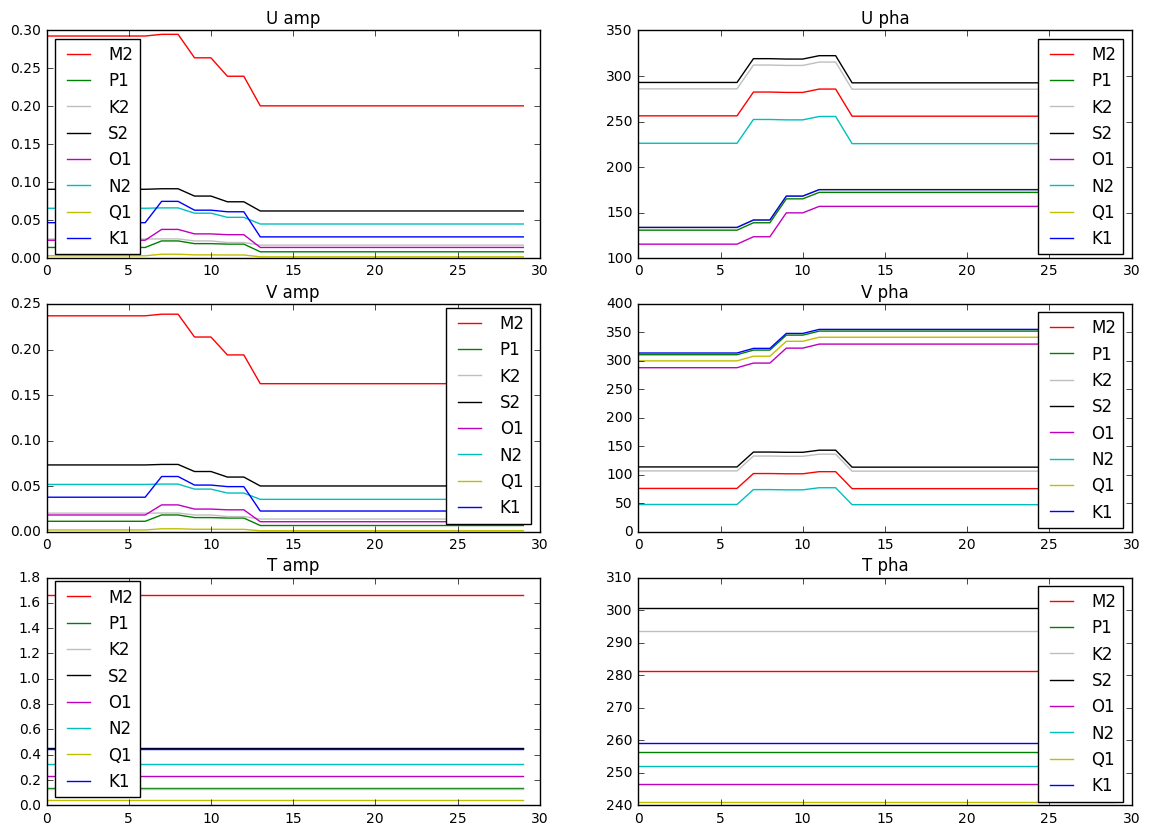

In [14]:
cols = {'M2':'r', 'K1': 'b','O1': 'm', 'S2': 'k','P1': 'g', 'N2': 'c', 'Q1': 'y', 'K2': '0.75'}
plt.figure(figsize=(14,10))
for key in consts_full:
    pylab.subplot(3,2,1)
    pylab.plot(Us_North_amp[key],cols[key],label=key)
    pylab.title('U amp')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,2)
    pylab.plot(np.degrees(Us_North_pha[key]),cols[key],label=key)
    pylab.title('U pha')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,3)
    pylab.plot(Vs_North_amp[key],cols[key],label=key)
    pylab.title('V amp')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,4)
    pylab.plot(np.degrees(Vs_North_pha[key]),cols[key],label=key)
    pylab.title('V pha')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,5)
    pylab.plot(Ts_North_amp[key],cols[key],label=key)
    pylab.title('T amp')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,6)
    pylab.plot(np.degrees(Ts_North_pha[key]),cols[key],label=key)
    pylab.title('T pha')
    pylab.legend(loc=0)
    
    

Now convert to the form that NEMO likes:

$Z_1 = A\cos(\phi)$ and $Z_2=A\sin(\phi)$

In [15]:
U1s = {}
U2s = {}

V1s = {}
V2s = {}

T1s = {}
T2s = {}

for key in consts_full:
    U1s[key] = Us_North_amp[key]*np.cos(Us_North_pha[key]); X=np.array(U1s[key]); U1s[key]=np.reshape(X,(len(X),1))
    U2s[key] = Us_North_amp[key]*np.sin(Us_North_pha[key]); X=np.array(U2s[key]); U2s[key]=np.reshape(X,(len(X),1))
    
    V1s[key] = Vs_North_amp[key]*np.cos(Vs_North_pha[key]); X=np.array(V1s[key]); V1s[key]=np.reshape(X,(len(X),1))
    V2s[key] = Vs_North_amp[key]*np.sin(Vs_North_pha[key]); X=np.array(V2s[key]); V2s[key]=np.reshape(X,(len(X),1))
    
    T1s[key] = Ts_North_amp[key]*np.cos(Ts_North_pha[key]); X=np.array(T1s[key]); T1s[key]=np.reshape(X,(len(X),1))
    T2s[key] = Ts_North_amp[key]*np.sin(Ts_North_pha[key]); X=np.array(T2s[key]); T2s[key]=np.reshape(X,(len(X),1))

Check with a plot

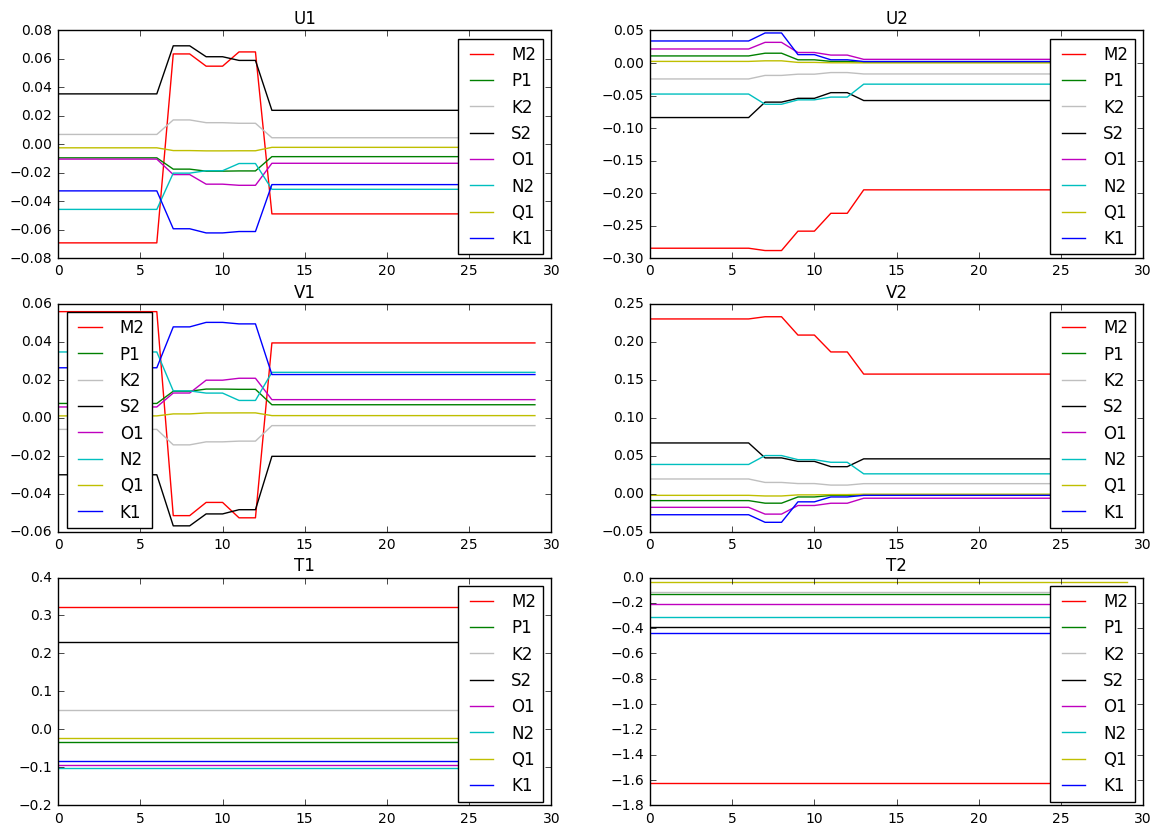

In [16]:
cols = {'M2':'r', 'K1': 'b','O1': 'm', 'S2': 'k','P1': 'g', 'N2': 'c', 'Q1': 'y', 'K2': '0.75'}
plt.figure(figsize=(14,10))
for key in consts_full:
    pylab.subplot(3,2,1)
    pylab.plot(U1s[key],cols[key],label=key)
    pylab.title('U1')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,2)
    pylab.plot(U2s[key],cols[key],label=key)
    pylab.title('U2')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,3)
    pylab.plot(V1s[key],cols[key],label=key)
    pylab.title('V1')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,4)
    pylab.plot(V2s[key],cols[key],label=key)
    pylab.title('V2')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,5)
    pylab.plot(T1s[key],cols[key],label=key)
    pylab.title('T1')
    pylab.legend(loc=0)
    
    pylab.subplot(3,2,6)
    pylab.plot(T2s[key],cols[key],label=key)
    pylab.title('T2')
    pylab.legend(loc=0)
    

Save N2, P1, Q1, K2 and the U/V components of O1, S2

In [17]:
#reload(webtide_tools)
#wait.... what about the U and V being on different grids?
#.... nothing really changes because we don't have great spatial resolution of measurements...
#... perhaps we'll need to make an extra cell for the V grid....
#currents
print (X.shape)
saves={'S2': [], 'O1': [], 'N2': [], 'P1': [], 'Q1': [], 'K2': []} 
for key in saves:
    webtide_tools.create_northern_tides_contd(U1s[key],U2s[key],'U',key,code, name='SalishSea')
    webtide_tools.create_northern_tides_contd(V1s[key],V2s[key],'V',key,code, name='SalishSea')
    webtide_tools.create_northern_tides_contd(T1s[key][0,0],T2s[key][0,0],'T',key,code, name='SalishSea')


(30,)
file format: NETCDF4
Conventions: CF-1.6
title: Tidal Boundary Conditions for Northern Boundary
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/johnstone_tides_contd.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/open_boundaries/north/tides/SalishSea2_North_tide_P1_grid_U.nc
history: [2017-04-07 13:39:15] Created netCDF4 zlib=True dataset.
comment: Tidal current and amplitude data scaled based on differences between K1/M2 and North observations and webtide.
(1, 30)
file format: NETCDF4
Conventions: CF-1.6
title: Tidal Boundary Conditions for Northern Boundary
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/johnstone_tides_contd.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/open_boundaries/north/tides/SalishSea2_North_tide_P1_grid_V.nc
history: [

Now that the files are created, I will copy them over to NEMO-forcing and commit.